In [1]:
import os
import h5py
import json
import time
import pyccl
import scipy
import numpy
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
#Data path
PATH = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'

DATA_PATH = PATH + 'DATA/'


In [3]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NN'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)
BIN_SIZE = 5
GRID_SIZE = 300
DATA_SIZE = 400000
#float64
REDSHIFT_GRID = numpy.linspace(0.005, 2.995, 300)
# Load
with h5py.File(os.path.join(synthesize_folder, '{}/{}_{}.hdf5'.format(tag, typ, label)), 'r') as file:
    DATA_GRID = numpy.array(file['lens']['data'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'double')

In [4]:
# Cosmology
# COSMOLOGY

with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    
    COSMO = json.load(file)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu=COSMO['M_NU'],
    Neff = COSMO['N_EFF'],
    Omega_k = COSMO['OMEGA_K'], 
    Omega_c = COSMO['OMEGA_CDM'], 
    Omega_b = COSMO['OMEGA_B'], 
    Omega_g=COSMO['OMEGA_GAMMA'],
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [5]:
def power_m(chi_data, chi_grid, power_grid, redshift_grid):
    ell_size = power_grid.shape[0]
    data_size = chi_data.shape[0] - 1
    grid_size = chi_grid.shape[0] - 1
    power = numpy.zeros((ell_size, data_size + 1))

    for k in range(data_size + 1):
        # 修正1：clip chi_data，防止越界
        xk = numpy.clip(chi_data[k], chi_grid[0], chi_grid[-1])
        where_arr = numpy.where(chi_grid <= xk)[0]

        if len(where_arr) == 0:
            n = 0
        else:
            n = numpy.max(where_arr)

        if n < grid_size:
            if n == 0:
                power[:,k] = (xk**3)/(chi_grid[1]**3)*power_grid[:, 1]
            else:
                w = (chi_grid[n + 1] - xk) / (chi_grid[n + 1] - chi_grid[n])
                power[:,k] = w * power_grid[:, n] + (1 - w) * power_grid[:, n + 1]
        else:
            power[:,k] = 0

    return power


In [6]:
#Compare different numeric equations

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'float32')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

CHI_SIZE = 1000
REDSHIFT_DATA = numpy.linspace(REDSHIFT_GRID.min(), REDSHIFT_GRID.max(), CHI_SIZE + 1)

CHI_DATA = COSMO_CCL.comoving_radial_distance(a = 1 / (1 + REDSHIFT_DATA))
A_DATA = pyccl.background.scale_factor_of_chi(cosmo = COSMO_CCL, chi = CHI_DATA)

ELL_SIZE = 200
ELL_DATA = numpy.logspace(2, 4, ELL_SIZE + 1)
CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ELL_DATA)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE + 1, GRID_SIZE)) + numpy.inf, where = CHI_MESH > 0))

POWER_GRID = numpy.zeros((ELL_SIZE + 1, GRID_SIZE))
for GRID_INDEX in range(GRID_SIZE):

    POWER_GRID[:,GRID_INDEX] = COSMO_CCL.linear_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])

POWER_DATA1 = scipy.interpolate.interp1d(CHI_GRID, POWER_GRID, kind = 'slinear', fill_value="extrapolate")(CHI_DATA) 
POWER_DATA2 = scipy.interpolate.interp1d(CHI_GRID, POWER_GRID, kind = 'quadratic', fill_value="extrapolate")(CHI_DATA)
POWER_DATA3 = scipy.interpolate.interp1d(CHI_GRID, POWER_GRID, kind = 'cubic', fill_value="extrapolate")(CHI_DATA) 
POWER_DATA = power_m(chi_data = CHI_DATA, chi_grid = CHI_GRID, power_grid = POWER_GRID, redshift_grid = REDSHIFT_GRID)

CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_DATA, ELL_DATA)
SCALE_DATA = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ELL_SIZE + 1, CHI_SIZE + 1)) + numpy.inf, where = CHI_MESH > 0))

POWER_CCL = numpy.zeros((ELL_SIZE + 1, CHI_SIZE + 1))
for DATA_INDEX in range(CHI_SIZE + 1):

    POWER_CCL[:,DATA_INDEX] = COSMO_CCL.linear_matter_power(k = SCALE_DATA[:,DATA_INDEX], a = A_DATA[DATA_INDEX])

POWER_RATIO = numpy.divide(POWER_DATA, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)
POWER_RATIO1 = numpy.divide(POWER_DATA1, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)
POWER_RATIO2 = numpy.divide(POWER_DATA2, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)
POWER_RATIO3 = numpy.divide(POWER_DATA3, POWER_CCL, out = numpy.ones(POWER_CCL.shape), where = POWER_CCL > 0)

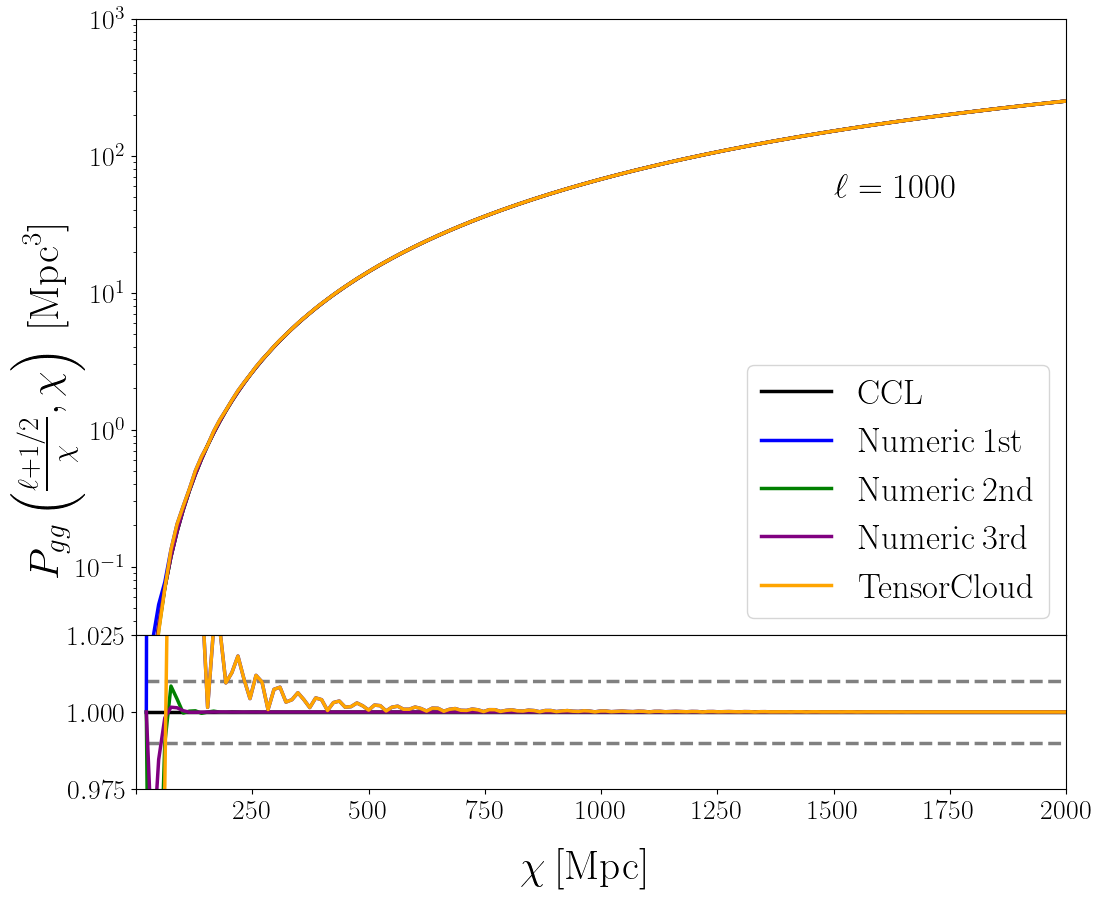

In [7]:
#Plot the results 

ELL_INDEX = 100
pyplot.rcParams['font.size'] = 20
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

PLOT = FIGURE.add_subplot(GRIDSPEC[:8,:])

PLOT.plot(CHI_DATA, POWER_CCL[ELL_INDEX,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

PLOT.plot(CHI_DATA, POWER_DATA1[ELL_INDEX,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

PLOT.plot(CHI_DATA, POWER_DATA2[ELL_INDEX,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')

PLOT.plot(CHI_DATA, POWER_DATA3[ELL_INDEX,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

PLOT.plot(CHI_DATA, POWER_DATA[ELL_INDEX,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

PLOT.text(x = 1500, y = 50, s = r'$\ell = {:.0f}$'.format(ELL_DATA[ELL_INDEX]), fontsize = 25)

PLOT.set_yscale('log')
PLOT.set_xlim(0, 2000)
PLOT.set_ylim(10**-1.5, 10**+3.0)

PLOT.set_xticklabels([])
PLOT.get_yticklabels()[0].set_visible([])
PLOT.legend(loc = 'lower right', fontsize = 25)

PLOT = FIGURE.add_subplot(GRIDSPEC[8:,:])

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(CHI_DATA, POWER_RATIO1[ELL_INDEX,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, POWER_RATIO2[ELL_INDEX,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, POWER_RATIO3[ELL_INDEX,:], color = 'purple', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, POWER_RATIO[ELL_INDEX,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xlim(0, 2000)
PLOT.set_ylim(0.975, 1.025)
PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\chi \: [\mathrm{Mpc}]$', fontsize = 30)
FIGURE.supylabel(r'$P_{gg} \left( \frac{\ell + 1/2}{\chi}, \chi \right) \: [\mathrm{Mpc}^3]$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('Pgg.png')
FIGURE.show()

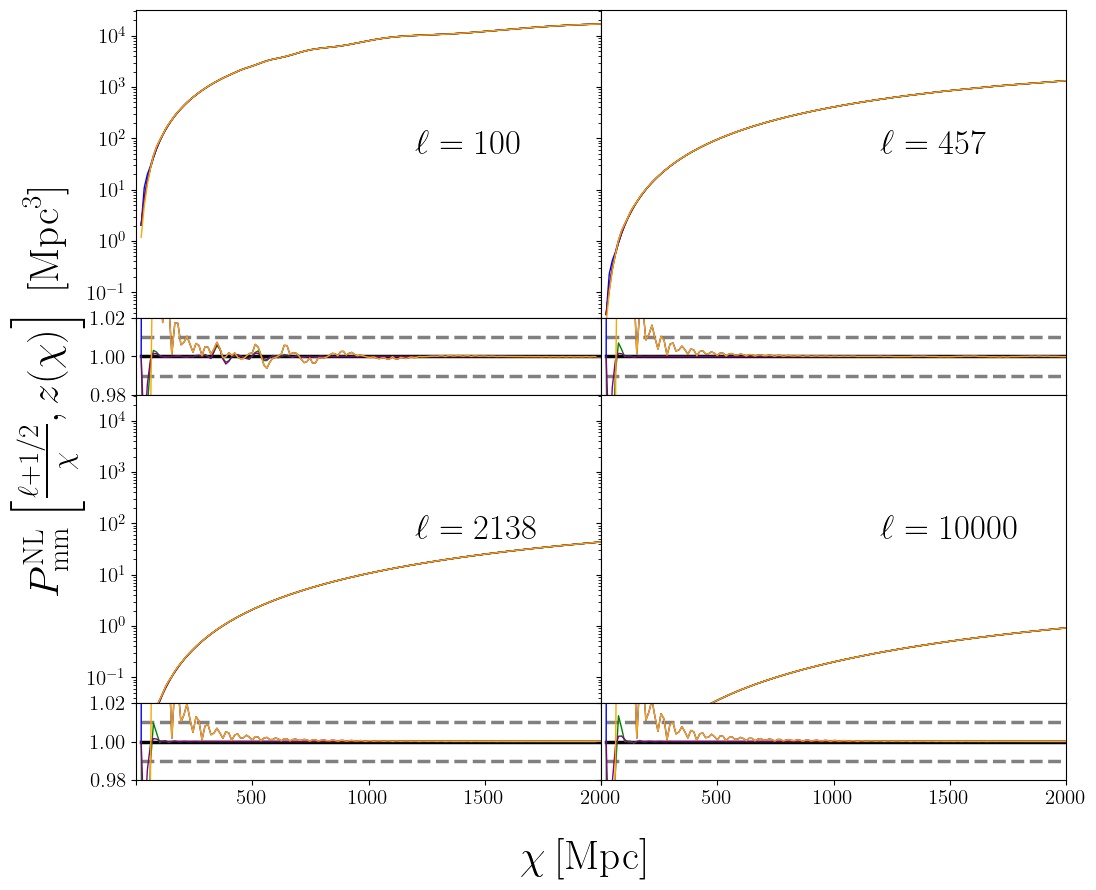

In [8]:
#Compare different l

PLOT_SIZE = 4
pyplot.rcParams['font.size'] = 15
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for PLOT_INDEX in range(PLOT_SIZE):

    ROW = PLOT_INDEX//2
    COLUMN = PLOT_INDEX%2
    ELL_INDEX = int(numpy.linspace(0, ELL_SIZE, PLOT_SIZE)[PLOT_INDEX])

    PLOT = FIGURE.add_subplot(GRIDSPEC[ROW * 5: ROW * 5 + 4, COLUMN * 6: COLUMN * 6 + 6])

    PLOT.plot(CHI_DATA, POWER_CCL[ELL_INDEX,:], color = 'black', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_DATA1[ELL_INDEX,:], color = 'blue', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_DATA2[ELL_INDEX,:], color = 'green', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_DATA3[ELL_INDEX,:], color = 'purple', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_DATA[ELL_INDEX,:], color = 'orange', linestyle = '-', linewidth = 1.0)

    PLOT.text(x = 1200, y = 50, s = r'$\ell = {:.0f}$'.format(ELL_DATA[ELL_INDEX]), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xlim(0, 2000)
    PLOT.set_ylim(10**-1.5, 10**+4.5)

    PLOT.set_xticklabels([])
    if COLUMN > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[ROW * 5 + 4: ROW * 5 + 5, COLUMN * 6: COLUMN * 6 + 6])

    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(CHI_DATA, POWER_RATIO1[ELL_INDEX,:], color = 'blue', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_RATIO2[ELL_INDEX,:], color = 'green', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_RATIO3[ELL_INDEX,:], color = 'purple', linestyle = '-', linewidth = 1.0)

    PLOT.plot(CHI_DATA, POWER_RATIO[ELL_INDEX,:], color = 'orange', linestyle = '-', linewidth = 1.0)

    PLOT.set_xlim(0, 2000)
    PLOT.set_ylim(0.98, 1.02)

    if ROW == 0: PLOT.set_xticklabels([])
    if COLUMN > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\chi \: [\mathrm{Mpc}]$', fontsize = 30)
FIGURE.supylabel(r'$P_\mathrm{mm}^\mathrm{NL} \left[ \frac{\ell + 1/2}{\chi}, z(\chi) \right] \: [\mathrm{Mpc}^3]$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.show()